In [1]:
# pip install scrapy
# pip install --upgrade zope2

from collections import Counter
import foursquare
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import requests
from scrapy import Selector
from scrapy.http import HtmlResponse
import seaborn as sns
from sqlalchemy import create_engine
import sqlite3
import textacy
import textacy.data
import time
import unicodedata

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
food = pd.read_pickle('../Capstone Stuff/explore_endpoint_df.pkl')
vegan = food[food.vegan_venue_check == 'vegan']

In [3]:
print sorted(food.venue_rated.unique()), sorted(vegan.venue_rated.unique())

[5.3, 5.5, 5.9, 6.1, 6.2, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9.0, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 'rating_not_available'] [7.4, 7.6, 7.7, 7.8, 7.9, 8.0, 8.1, 8.3, 8.5, 8.6, 8.8, 8.9, 9.0]


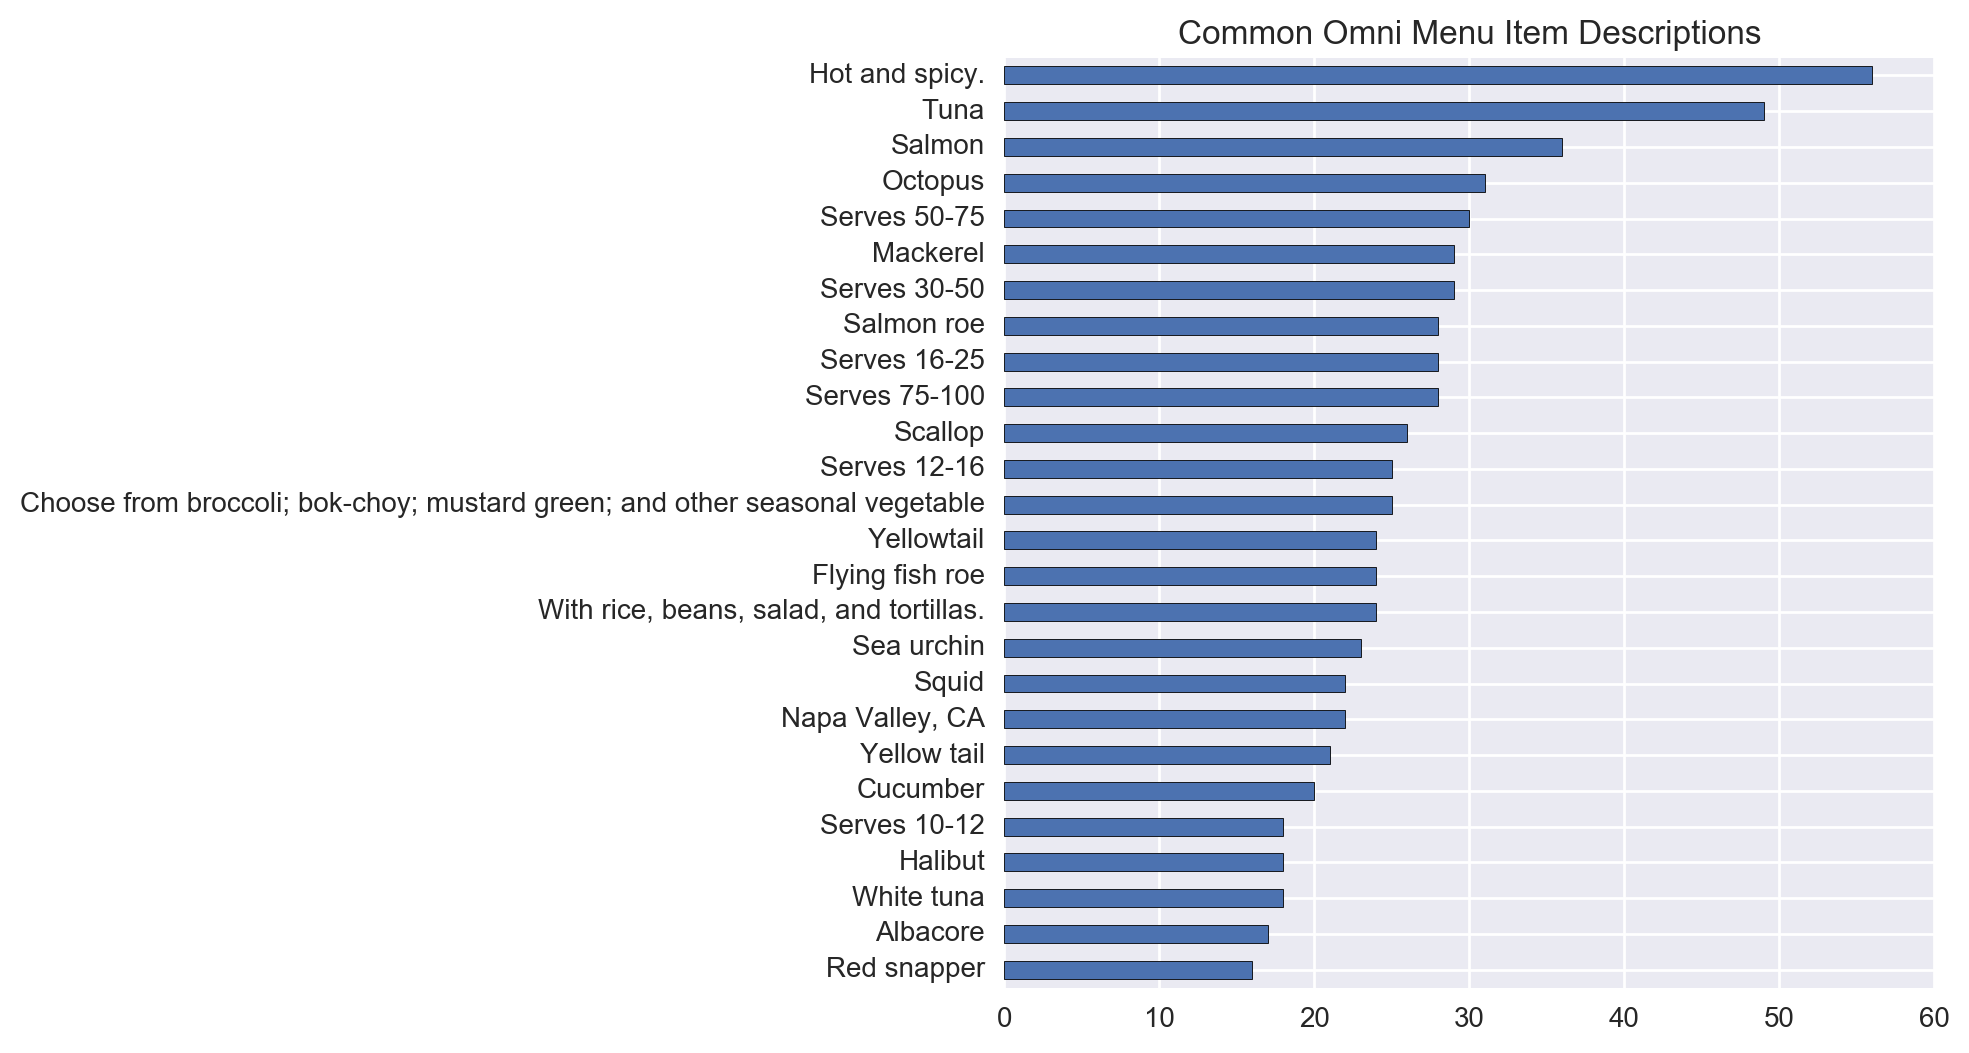

In [4]:
# Let's plot the most common item descriptions
desc_count = food[food.menu_item_desc != 'desc_not_available']
desc_count = desc_count[desc_count.groupby('menu_item_desc').menu_item_desc.transform(len) > 15]

plt.figure(figsize=(6,6))
desc_count['menu_item_desc'].value_counts().sort_values().plot(kind='barh')
plt.title('Common Omni Menu Item Descriptions')

# Turns out not to be terribly descriptive. We see a set of venues that use the same descriptions
# for a variety of different dishes - for example, the 'serves 50-75' (etc.) is from a single bakery.

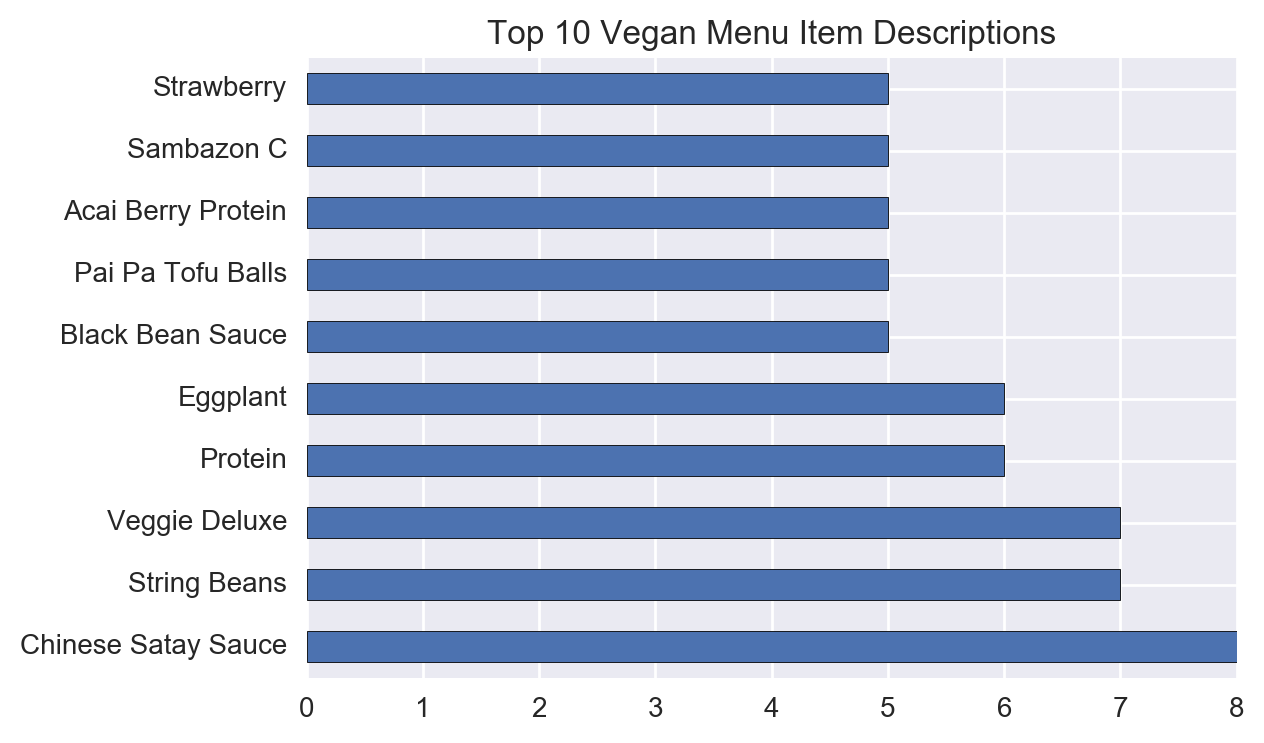

In [5]:
vegan_desc = vegan[vegan.menu_item_desc != 'desc_not_available']
vegan_desc = vegan_desc[vegan_desc.groupby('menu_item_desc').menu_item_desc.transform(len) > 0]
vegan_tops = vegan_desc.menu_item_name.value_counts()
vegan_tops = vegan_tops[:10]
vegan_tops.plot(kind='barh')

plt.title('Top %s Vegan Menu Item Descriptions' %len(vegan_tops))

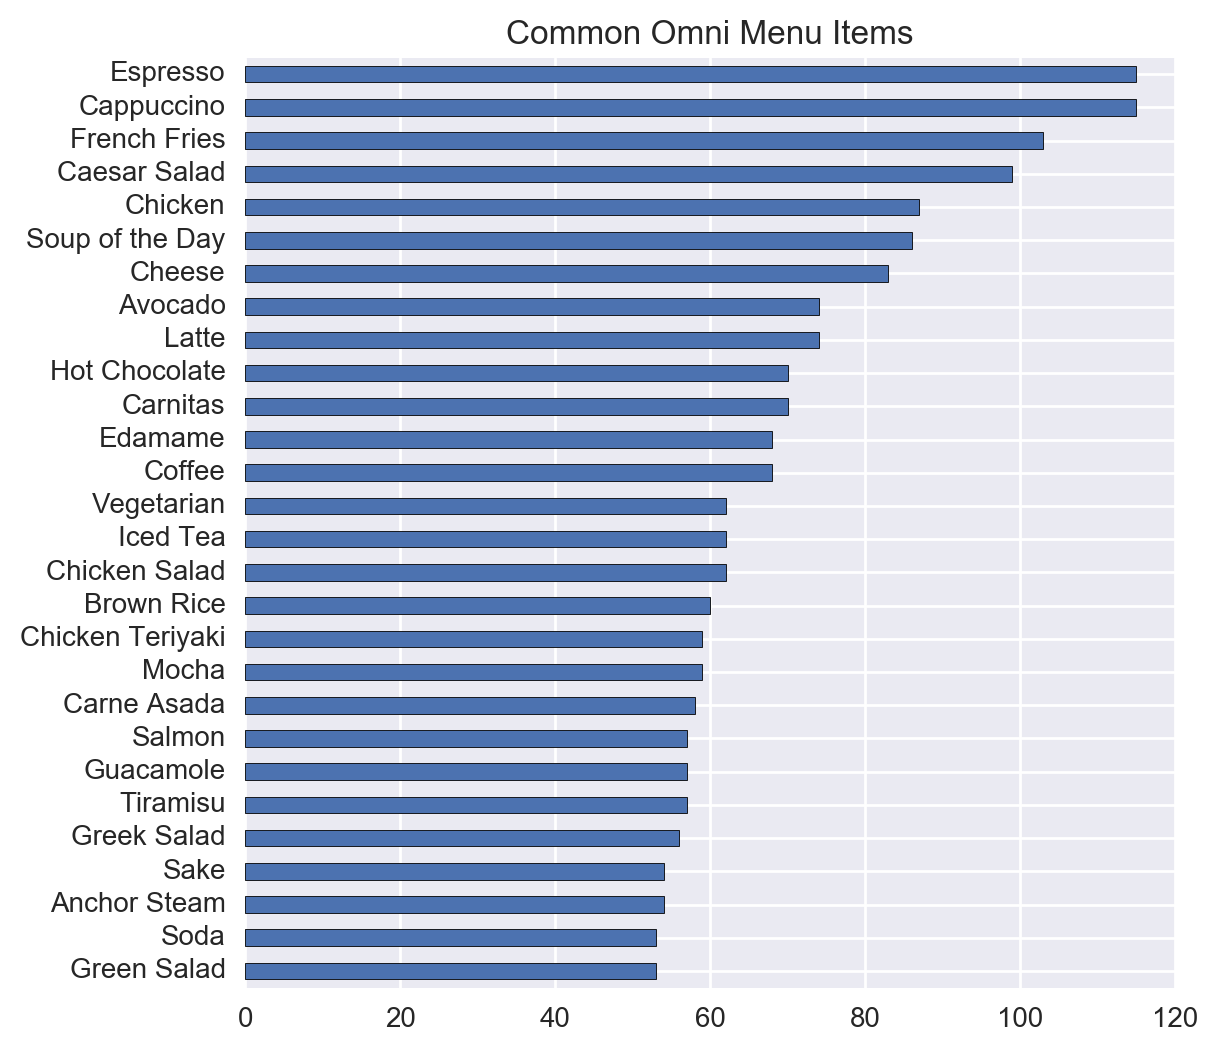

In [6]:
# Let's try the most common items
item_count = food[food.groupby('menu_item_name').menu_item_name.transform(len) > 50]
item_count.menu_item_name.value_counts()

plt.figure(figsize=(6,6))
item_count['menu_item_name'].value_counts().sort_values().plot(kind='barh')
plt.title('Common Omni Menu Items')

# Most commonly we see beverages and condiments. Otherwise, notable standouts include French Fries, Chicken Salad,
# Chicken Teriyaki, Salmon, Greek Salad, Green Salad, Tiramisu

In [7]:
# Out of curiosity, I'm going looking at the various descriptions under French Fries
food[food.menu_item_name == 'French Fries'].menu_item_desc.value_counts().head()

desc_not_available                         80
Smoky ketchup, sweet-onion aioli            2
Smoky tomato ketchup, sweet-onion aioli     2
Anchovy Ketchup                             2
With aioli                                  2
Name: menu_item_desc, dtype: int64

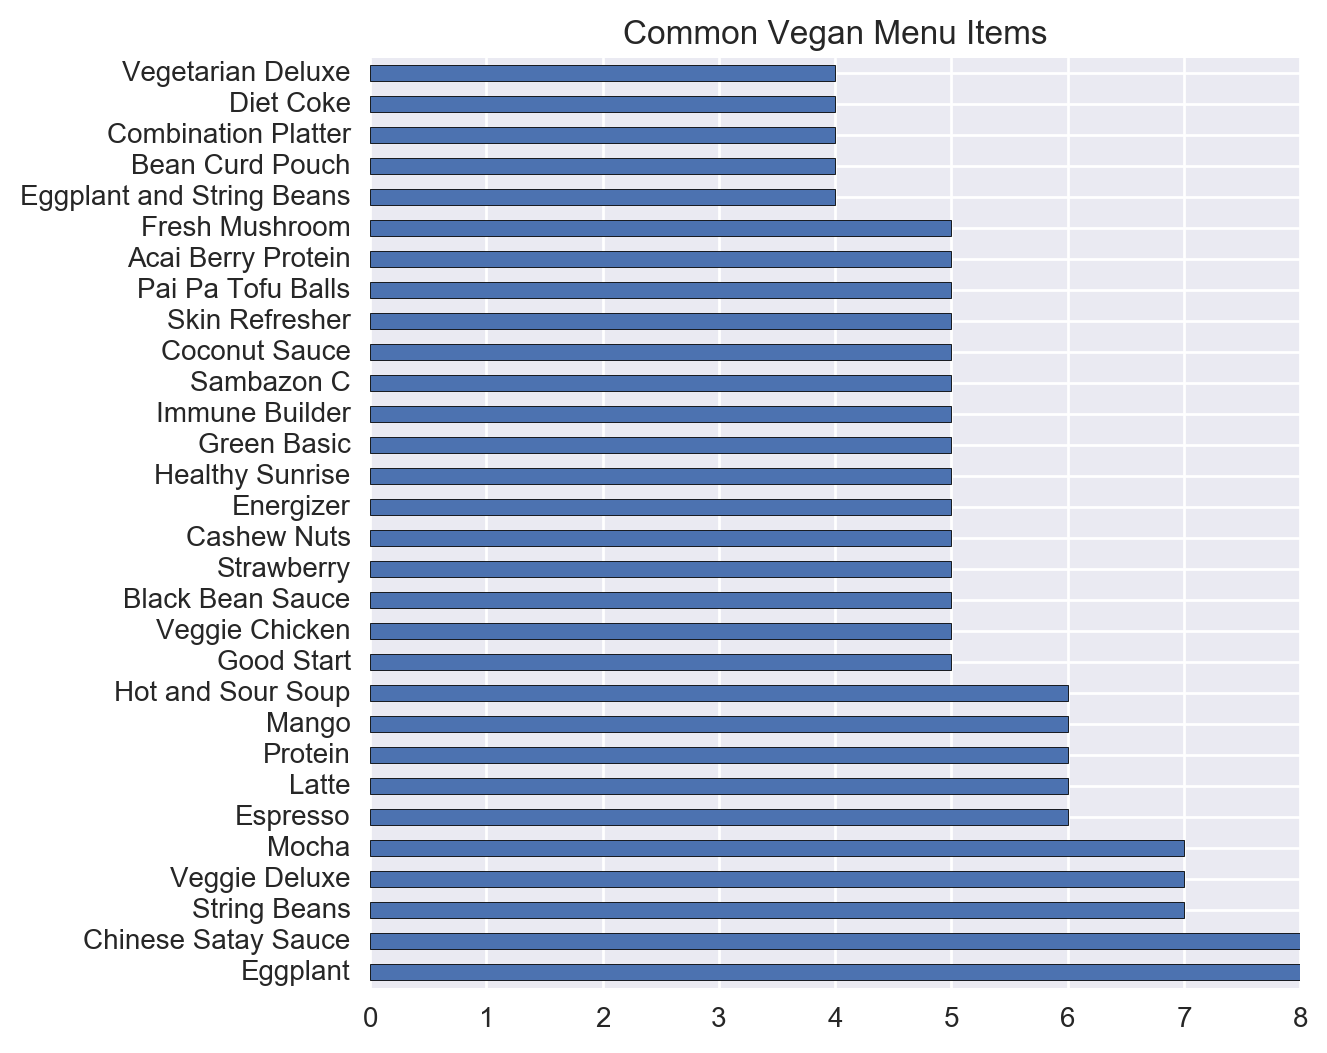

In [8]:
# Let's try the most common items
item_count = vegan[vegan.groupby('menu_item_name').menu_item_name.transform(len) > 0]
vegan_tops = item_count.menu_item_name.value_counts()

plt.figure(figsize=(6,6))
vegan_tops[:30].plot(kind='barh')
plt.title('Common Vegan Menu Items')

# This basically indicates that unlike 'omni' (or an omnivorous diet), vegan venues have very few menu items
# that can be found at different venues i.e. vegan venues tend to have unique menu items

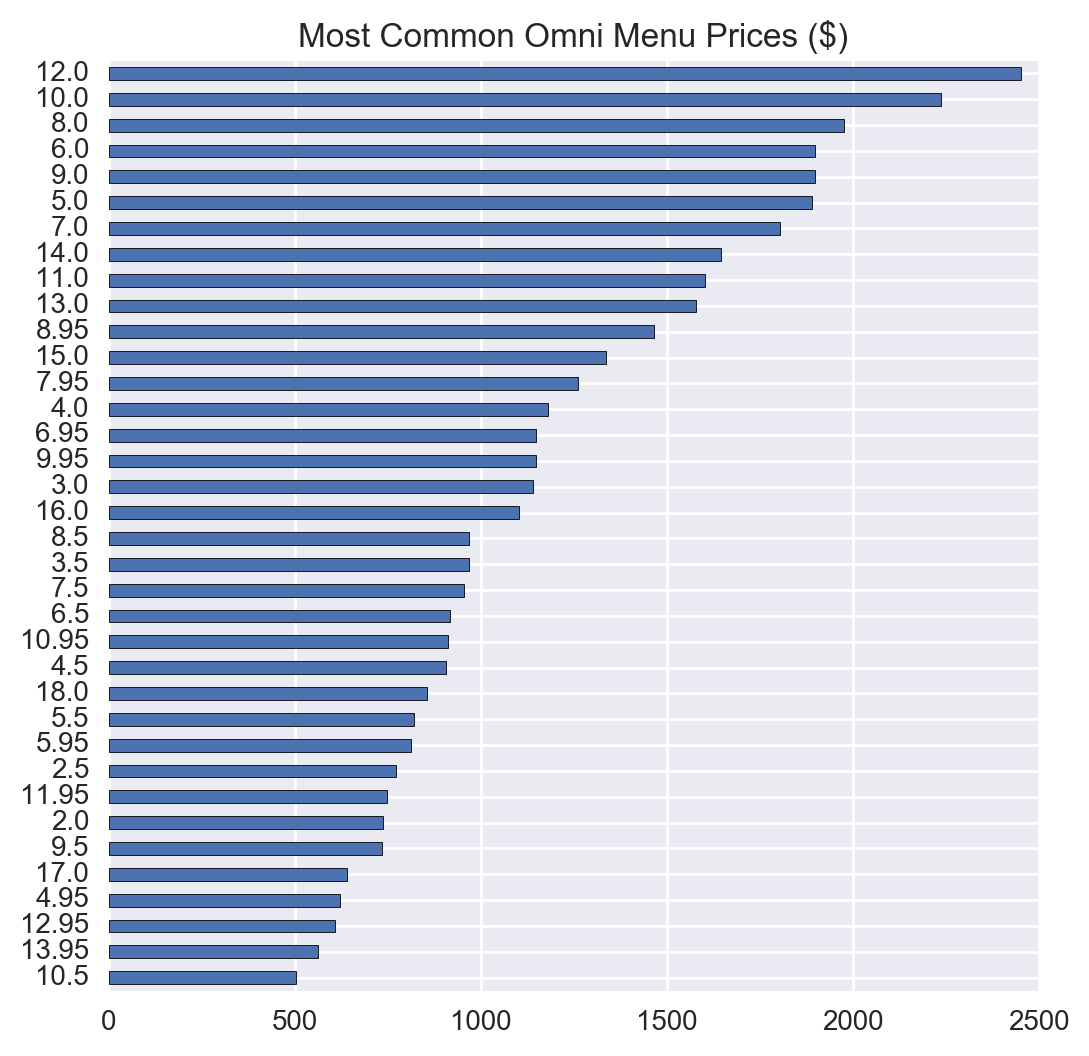

In [9]:
# Let's try the most common item prices
item_price = food[food.groupby('menu_item_price').menu_item_price.transform(len) > 500]
item_price = item_price[item_price.menu_item_price != 'price_not_available']
item_price.menu_item_price.value_counts()

plt.figure(figsize=(6,6))
item_price['menu_item_price'].value_counts().sort_values().plot(kind='barh')
plt.title('Most Common Omni Menu Prices ($)')

In [10]:
common_omni = food[food.menu_item_price != 'price_not_available']
lower_bound = 11.49
upper_bound = 12.49
common_omni = food[food.menu_item_price >= lower_bound][food.menu_item_price <= upper_bound]
print "Items in the $%.2f-$%.2f range:" % (lower_bound, upper_bound), len(set(common_omni.menu_item_name))
print "Percentage of unique items in the $%.2f-$%.2f range:" %(lower_bound, upper_bound), \
float(len(set(common_omni.menu_item_name)))/len(common_omni.menu_item_name)*100

# I ran a little experiment to see how many distinct menu items are priced at 12, and turns it is a lot!

Items in the $11.49-$12.49 range: 3274
Percentage of unique items in the $11.49-$12.49 range: 81.7070127277


/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


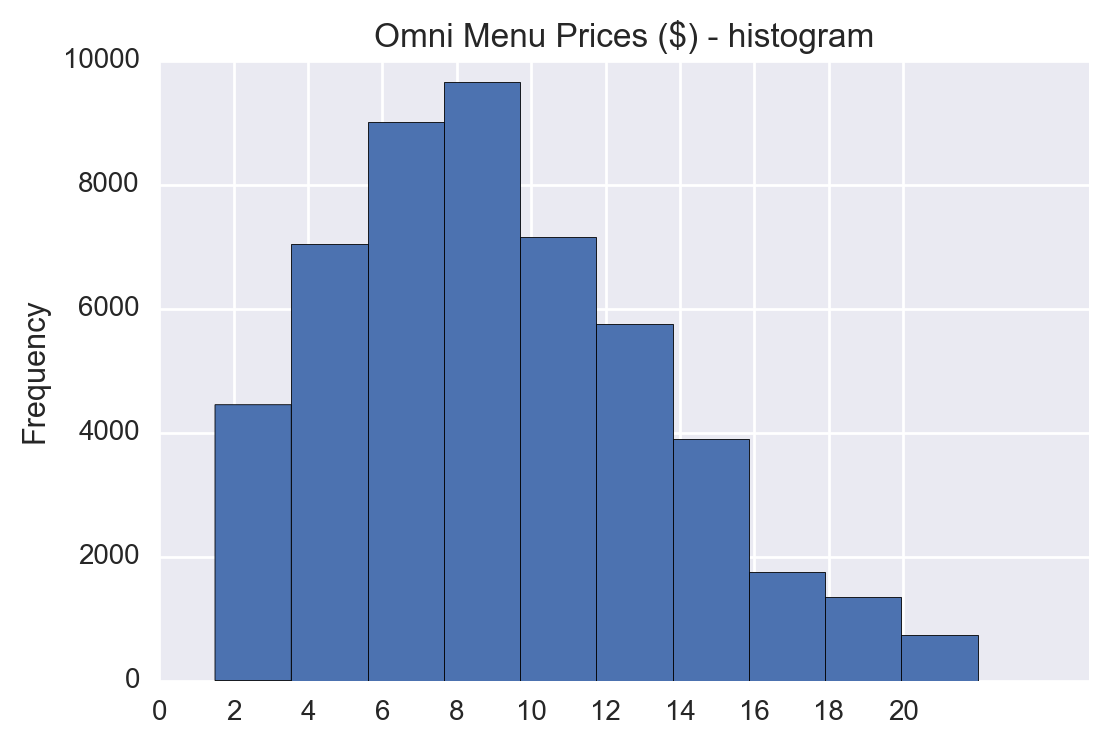

In [11]:
# Histogram of the same data, menu item prices - note how this is only including frequencies > 300
item_price = food[food.groupby('menu_item_price').menu_item_price.transform(len) > 300]
item_price = item_price[item_price.menu_item_price != 'price_not_available']
item_price.menu_item_price.value_counts()

item_price.menu_item_price.sort_values().plot(kind='hist', xticks=range(0,21,2))
plt.title('Omni Menu Prices ($) - histogram')

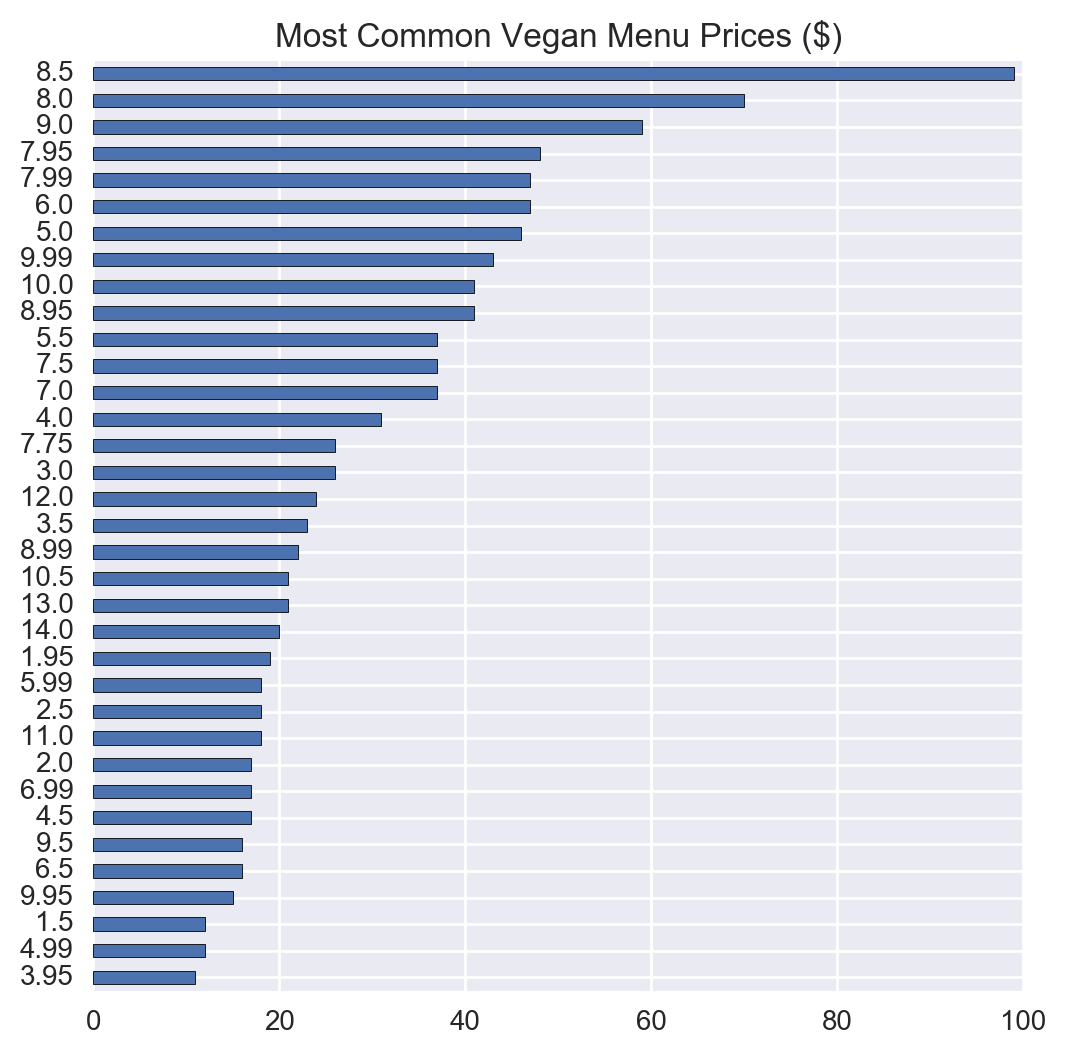

In [12]:
# Now for vegan item prices
vegan_price = vegan[vegan.groupby('menu_item_price').menu_item_price.transform(len) > 10]
vegan_price = vegan_price[vegan_price.menu_item_price != 'price_not_available']
vegan_price.menu_item_price.value_counts()

plt.figure(figsize=(6,6))
vegan_price['menu_item_price'].value_counts().sort_values().plot(kind='barh')
plt.title('Most Common Vegan Menu Prices ($)')

In [13]:
common_vegan = vegan[vegan.menu_item_price != 'price_not_available']
lower_bound = 7.99
upper_bound = 9.00
common_vegan = vegan[vegan.menu_item_price >= lower_bound][vegan.menu_item_price <= upper_bound]
print "Items in the $%.2f-$%.2f range:" % (lower_bound, upper_bound), len(set(common_vegan.menu_item_name))
print "Percentage of unique items in the $%.2f-$%.2f range:" %(lower_bound, upper_bound), \
float(len(set(common_vegan.menu_item_name)))/len(common_vegan.menu_item_name)*100

# Again, there are quite a few distinct menu items priced at the mode price, this time at 8.50

Items in the $7.99-$9.00 range: 267
Percentage of unique items in the $7.99-$9.00 range: 77.1676300578


/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


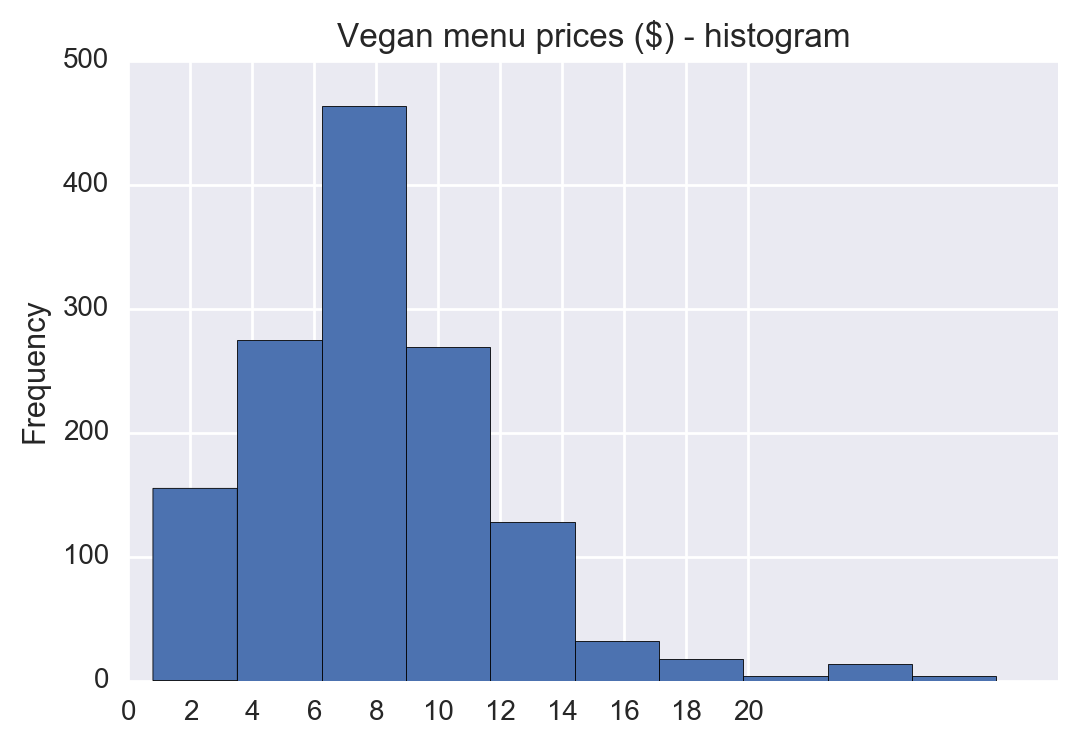

In [14]:
vegan_price = vegan[vegan.groupby('menu_item_price').menu_item_price.transform(len) > 3]
vegan_price = vegan_price[vegan_price.menu_item_price != 'price_not_available']
vegan_price.menu_item_price.value_counts()

vegan_price.menu_item_price.sort_values().plot(kind='hist', xticks=range(0,21,2))
plt.title('Vegan menu prices ($) - histogram')

# This histogram result is very interesting, particularly when compared to the Omni

# There is a range parameter; could make custom bins w/ sizing depending on what i'm looking for
# loop there a dictionary w/ keys as the bin ranges, and create features in my dataframe on that

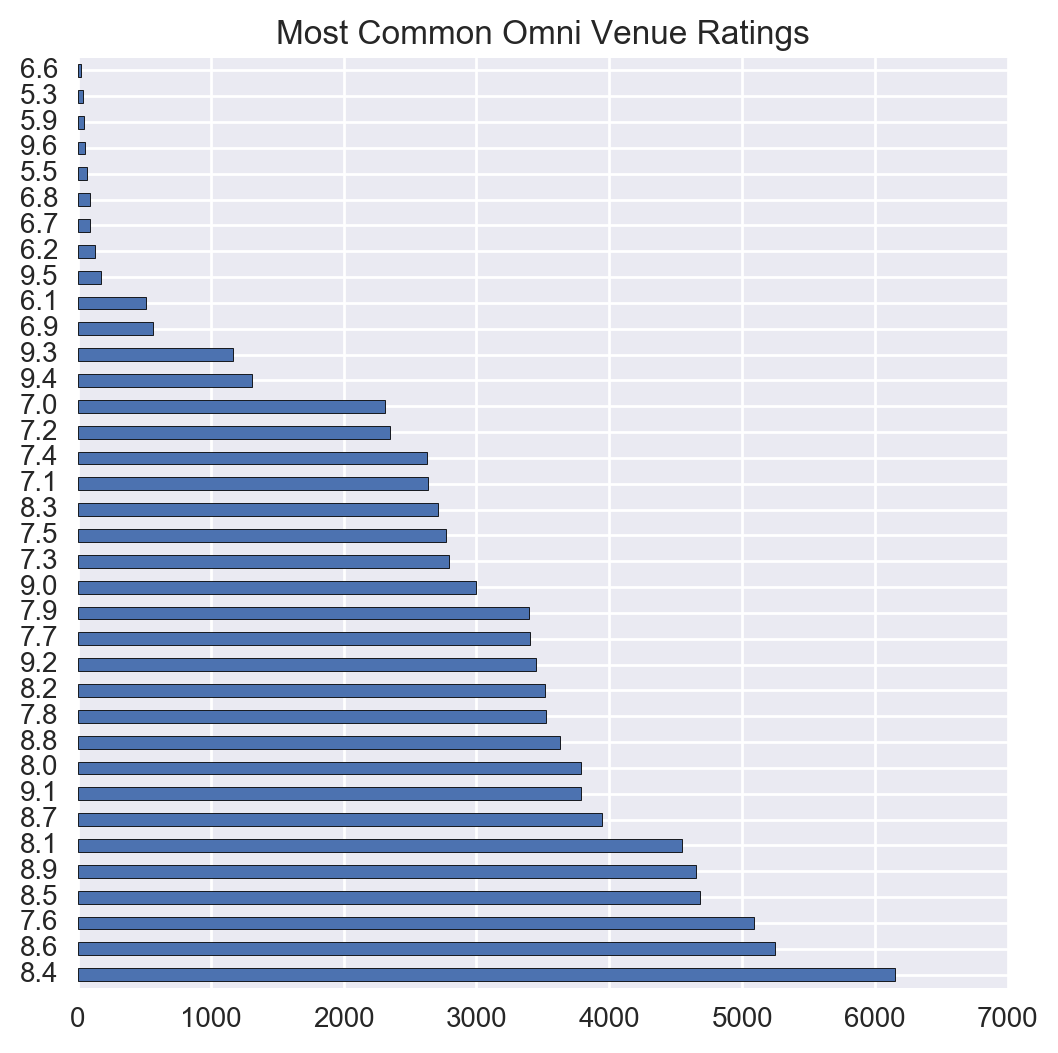

In [15]:
# Let's try looking at venue ratings
venue_rating = food[food.groupby('venue_rated').venue_rated.transform(len) > 0]
venue_rating = venue_rating[venue_rating.venue_rated != 'rating_not_available']
venue_rating.venue_rated.value_counts()

plt.figure(figsize=(6,6))
venue_rating.venue_rated.value_counts().plot(kind='barh')
plt.title('Most Common Omni Venue Ratings')

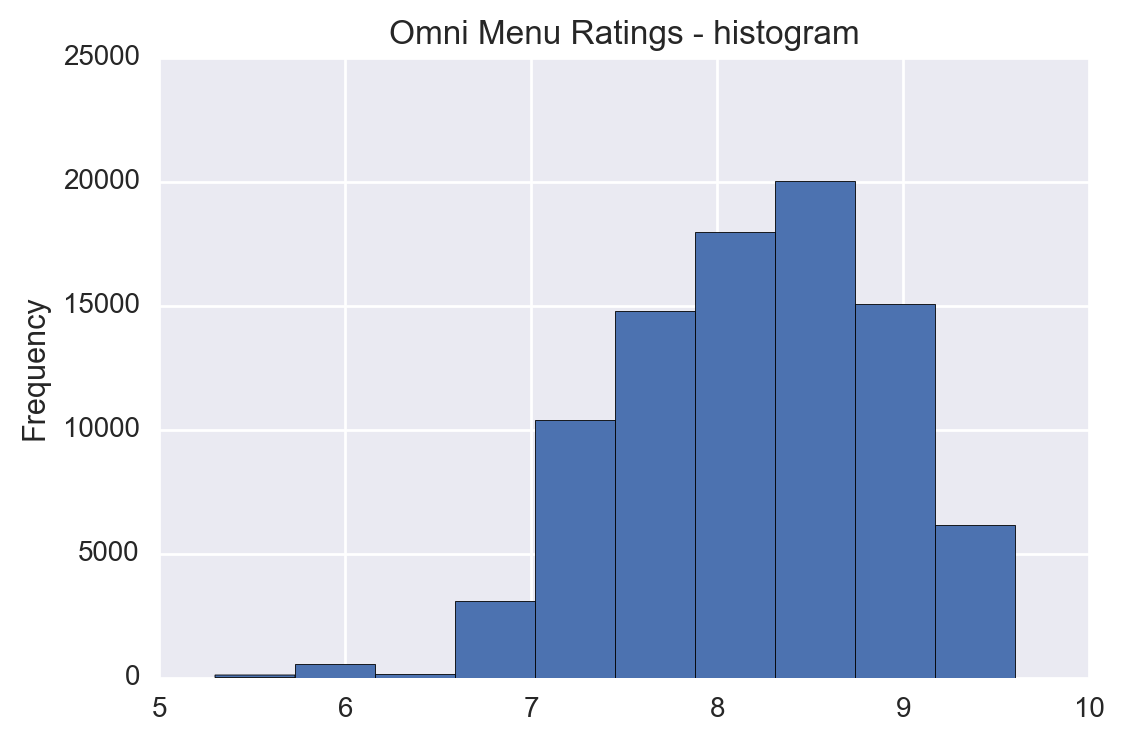

In [16]:
venue_rating = food[food.groupby('venue_rated').venue_rated.transform(len) > 0]
venue_rating = venue_rating[venue_rating.venue_rated != 'rating_not_available']
venue_rating.venue_rated.value_counts()

venue_rating.venue_rated.sort_values().plot(kind='hist')
plt.title('Omni Menu Ratings - histogram')

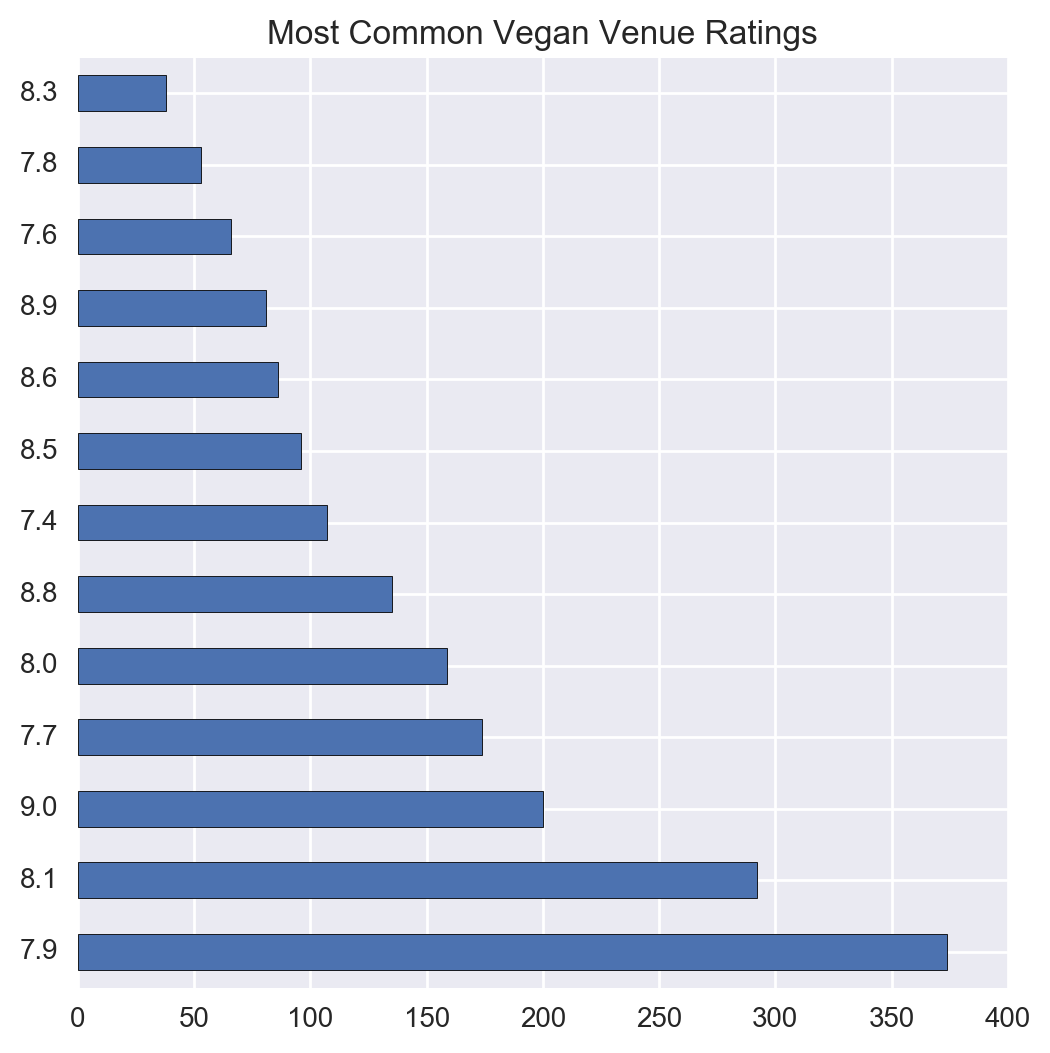

In [17]:
# Let's try looking at venue ratings
venue_rating = vegan[vegan.groupby('venue_rated').venue_rated.transform(len) > 0]
venue_rating = venue_rating[venue_rating.venue_rated != 'rating_not_available']
venue_rating.venue_rated.value_counts()

plt.figure(figsize=(6,6))
venue_rating.venue_rated.value_counts().plot(kind='barh')
plt.title('Most Common Vegan Venue Ratings')

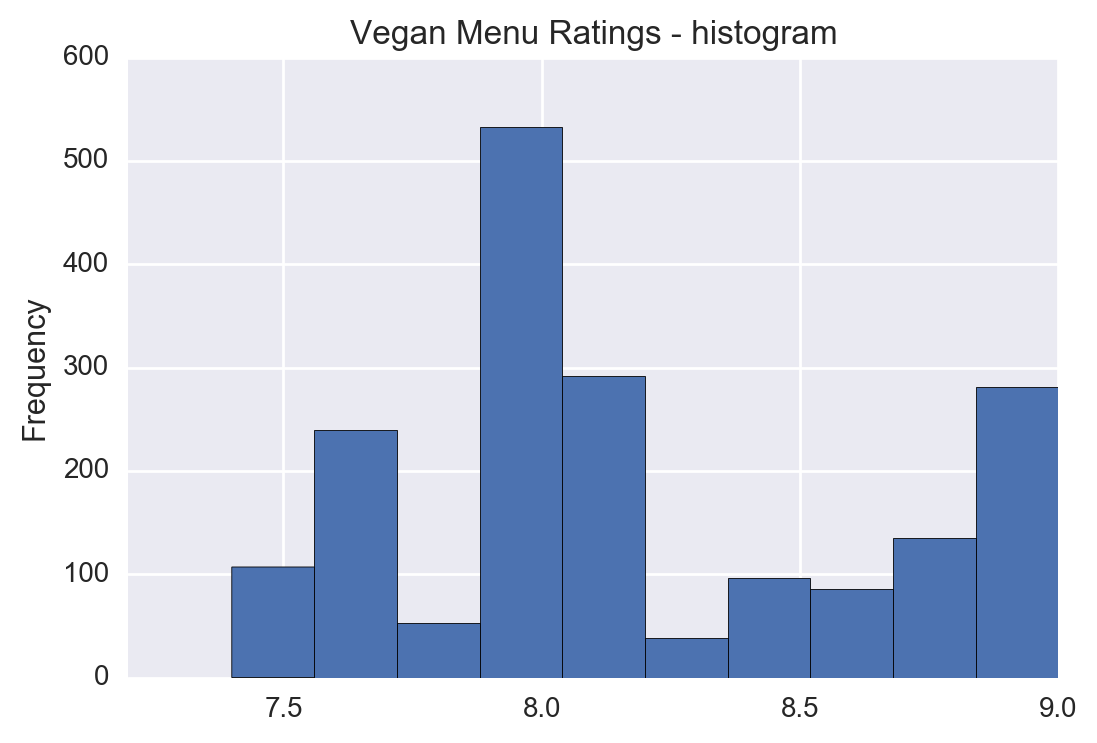

In [18]:
venue_rating = vegan[vegan.groupby('venue_rated').venue_rated.transform(len) > 0]
venue_rating = venue_rating[venue_rating.venue_rated != 'rating_not_available']
venue_rating.venue_rated.value_counts()

venue_rating.venue_rated.sort_values().plot(kind='hist')
plt.title('Vegan Menu Ratings - histogram')

Venues w/ the Appetizers submenu: 228
Venues w/ the Pasta submenu: 49
Venues w/ the Nigiri Sushi submenu: 15
Note: Largest vegan categories are too small to hold deductively reasoned value


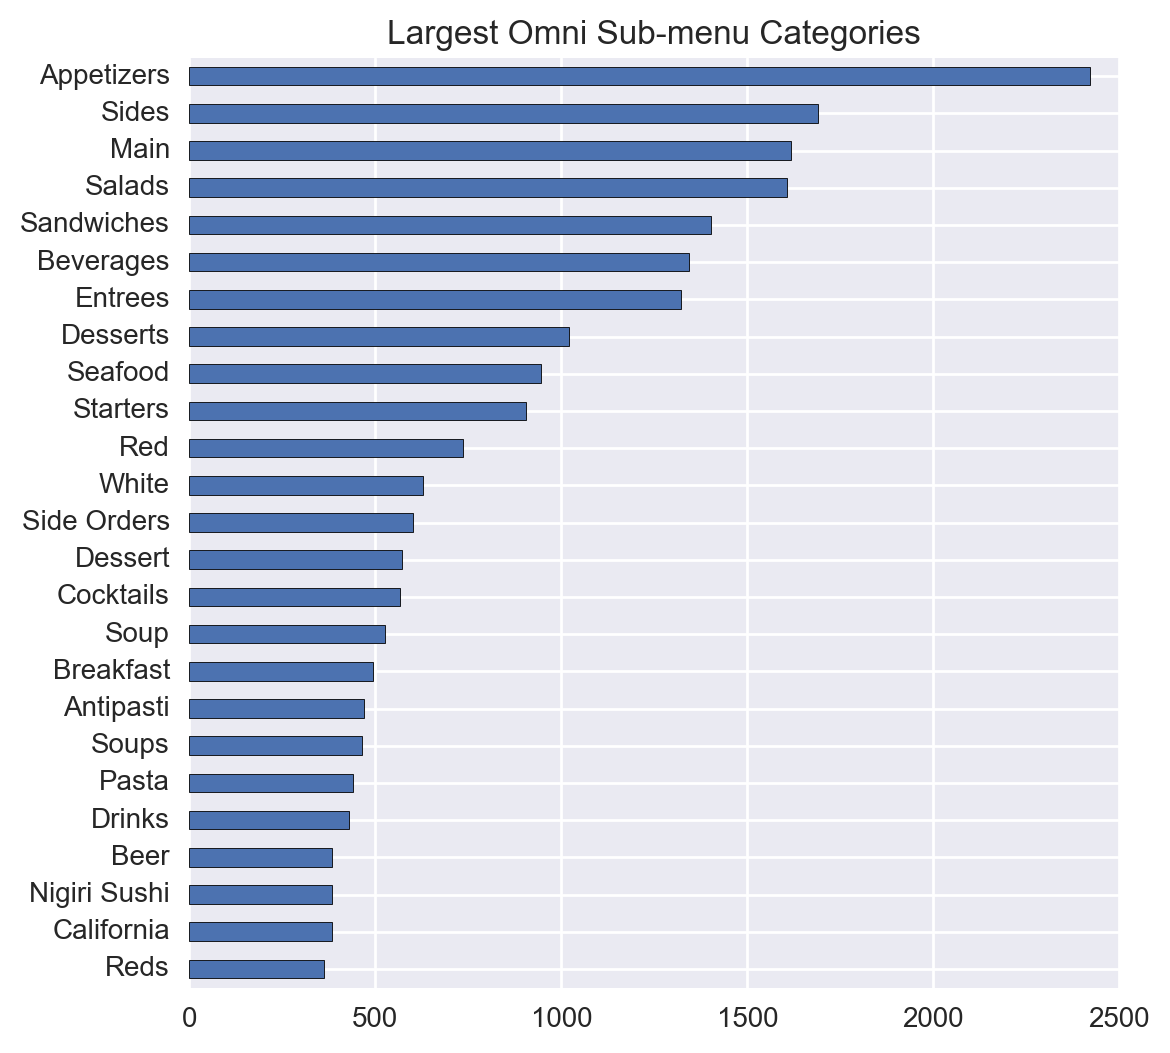

In [19]:
# Let's try the most common sub menu names
smenu_count = food[food.groupby('depth_menus_n').depth_menus_n.transform(len) > 350]
smenu_count.depth_menus_n.value_counts()

plt.figure(figsize=(6,6))
smenu_count['depth_menus_n'].value_counts().sort_values().plot(kind='barh')
plt.title('Largest Omni Sub-menu Categories')

# Most commonly, and unsurprisingly, we see a breakdown between starters, entrees, and desserts. We can note
# how steep the logarithmic appearance of the graph is, indicating the dominance of a handful of submenu titles.
app = food[food.depth_menus_n == 'Appetizers']
print 'Venues w/ the Appetizers submenu:', len(app.venue_name.value_counts())

# We also see beverages and drinks. It's also interesting to see how pasta has broken in.
pasta = food[food.depth_menus_n == 'Pasta']
print 'Venues w/ the Pasta submenu:', len(pasta.venue_name.value_counts())

# I was also interested to see nigiri come in, and originally concluded there was just a couple venues
# being overrepresented. However looking below, this is actually not the case.
nigiri = food[food.depth_menus_n == 'Nigiri Sushi']
print 'Venues w/ the Nigiri Sushi submenu:', len(nigiri.venue_name.value_counts())
print 'Note: Largest vegan categories are too small to hold deductively reasoned value'

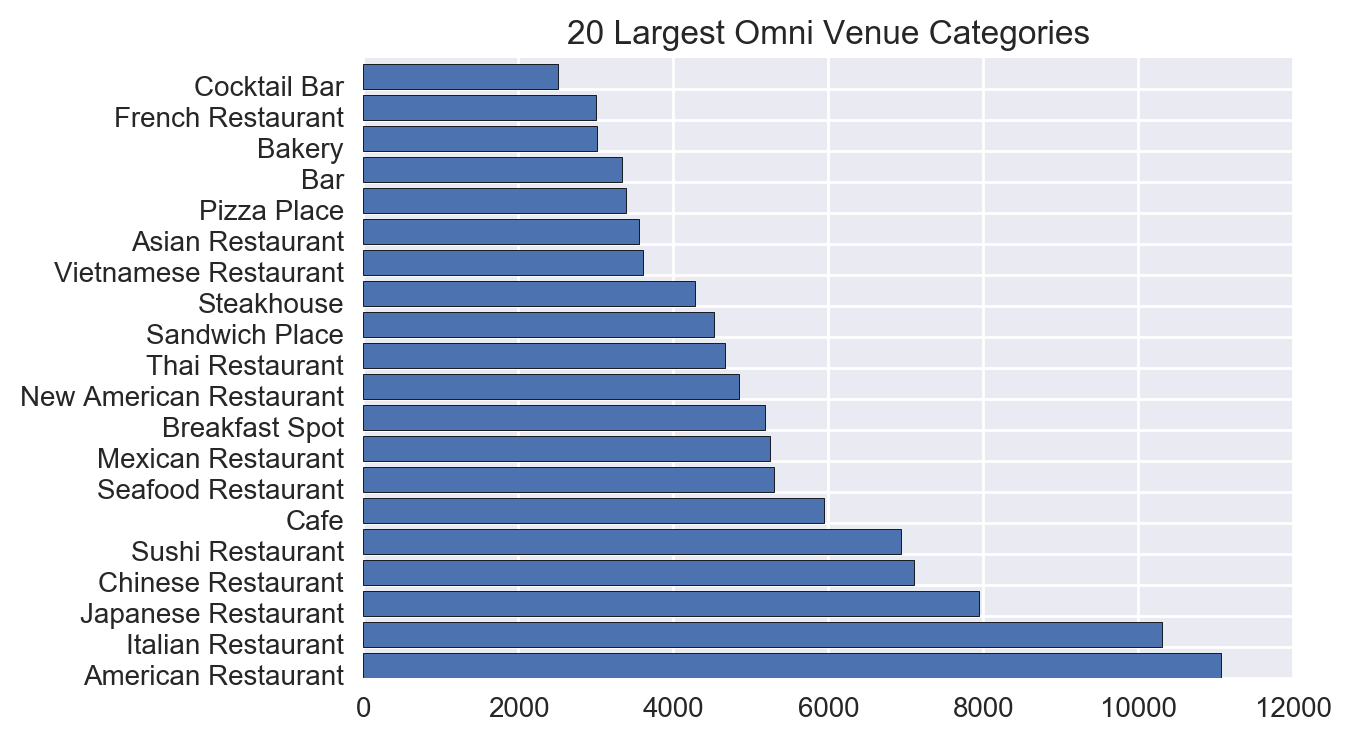

In [20]:
pop_venue_desc = [each_desc for desc_list in food.venue_desc_list for each_desc in desc_list]
pop_venues = Counter(pop_venue_desc).most_common()
pop_venues = pop_venues[:20]

fig, ax = plt.subplots()
ax.barh(range(len(pop_venues)), [counts[1] for counts in pop_venues])
ax.set_yticks(range(len(pop_venues)))
ax.set_yticklabels([counts[0] for counts in pop_venues])
ax.set_title('%s Largest Omni Venue Categories' %str(len(pop_venues))) 
plt.show()

#NOTE : It'd be nice to put the longest bar ontop, oh well

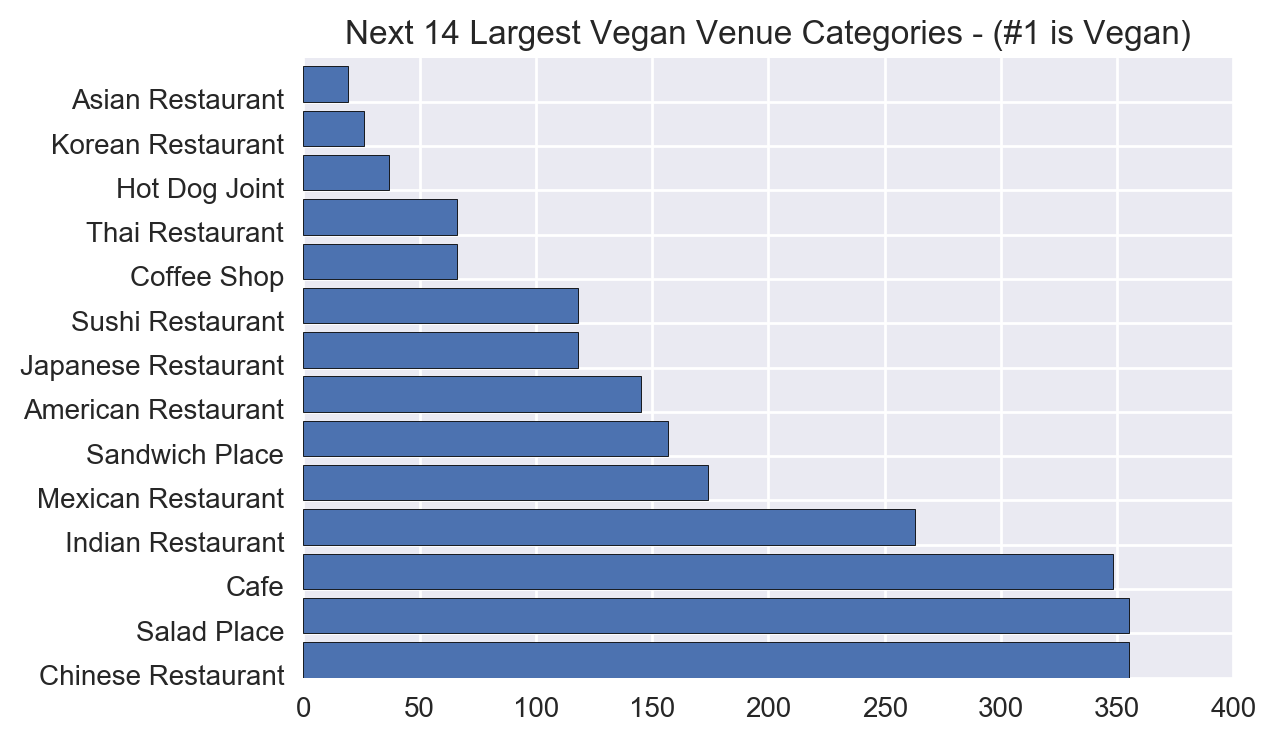

In [21]:
pop_venue_desc = [each_desc for desc_list in vegan.venue_desc_list for each_desc in desc_list]
pop_venues = Counter(pop_venue_desc).most_common()
pop_venues = pop_venues[1:15]

fig, ax = plt.subplots()
ax.barh(range(len(pop_venues)), [counts[1] for counts in pop_venues])
ax.set_yticks(range(len(pop_venues)))
ax.set_yticklabels([counts[0] for counts in pop_venues])
ax.set_title('Next %s Largest Vegan Venue Categories - (#1 is Vegan)' %str(len(pop_venues))) 
plt.show()

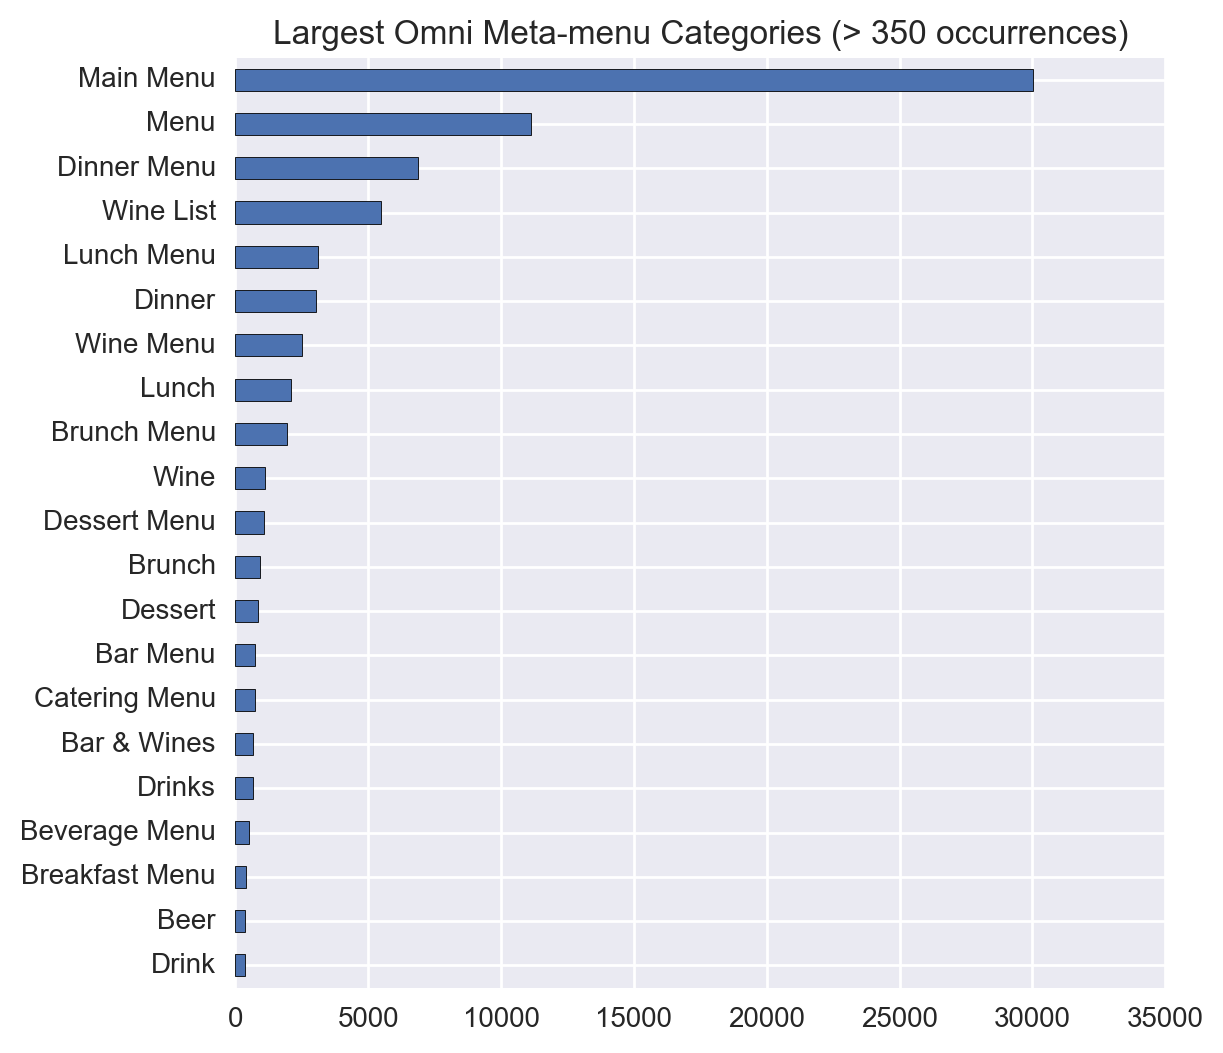

In [22]:
# Let's try the most common meta menu names
lim = 350
mmenu_count = food[food.groupby('meta_menu_n').meta_menu_n.transform(len) > lim]
mmenu_count.meta_menu_n.value_counts()

plt.figure(figsize=(6,6))
mmenu_count['meta_menu_n'].value_counts().sort_values().plot(kind='barh')
plt.title('Largest Omni Meta-menu Categories (> %d occurrences)' %lim)

# Sadly, not much to see here

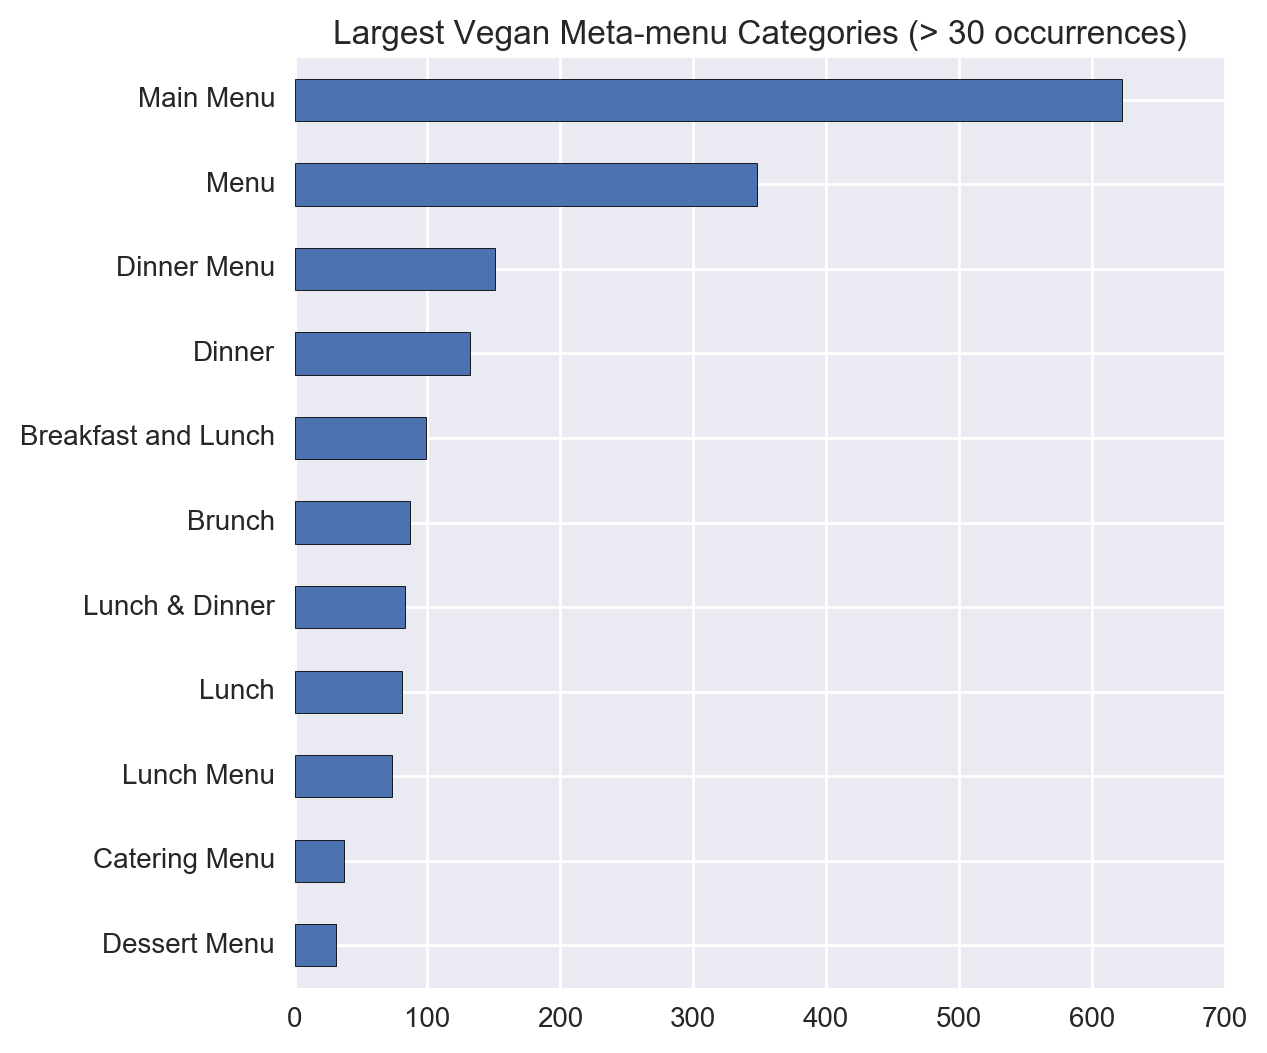

In [23]:
# Vegan meta-menu names
lim = 30
mmenu_count = vegan[vegan.groupby('meta_menu_n').meta_menu_n.transform(len) > lim]
mmenu_count.meta_menu_n.value_counts()

plt.figure(figsize=(6,6))
mmenu_count['meta_menu_n'].value_counts().sort_values().plot(kind='barh')
plt.title('Largest Vegan Meta-menu Categories (> %d occurrences)' %lim)

In [24]:
def word_counter(unique_desc):
    single_string = ' '.join(unique_desc)
    count_string = len(single_string.split())
    return count_string

In [25]:
#have to count the number of words in each list and add this as a new column to the dataframe
update_to_food = food

update_to_food['count_desc_list'] = food.venue_desc_list.map(lambda x: word_counter(x))

In [26]:
def item_desc_counter(phrase):
    if phrase == 'desc_not_available':
        return 0
    else:
        countered = len(phrase.split())
        return countered

In [27]:
update_to_food['count_item_name'] = food.menu_item_name.map(lambda x: len(x.split()))
update_to_food['count_item_desc'] = food.menu_item_desc.map(lambda x: item_desc_counter(x))

In [28]:
update_to_food.head()
vegan_update = update_to_food[update_to_food.vegan_venue_check == 'vegan']
vegan_update.head()

,venue_name,venue_desc_list,vegan_venue_check,venue_menu_url,venue_rated,meta_menu_n,depth_menus_n,menu_item_name,menu_item_price,menu_item_desc,count_desc_list,count_item_name,count_item_desc
1064,Amber India,"[Indian Restaurant, Vegetarian / Vegan Restaur...",vegan,https://foursquare.com/v/amber-india/4acab395f...,8.6,Dessert Menu,"Ports, Madeira, & Dessert Wines","Tokaji, Disznoko, Kesoi Szuret, Hungary '08",9,desc_not_available,6,6,0
1065,Amber India,"[Indian Restaurant, Vegetarian / Vegan Restaur...",vegan,https://foursquare.com/v/amber-india/4acab395f...,8.6,Dessert Menu,"Ports, Madeira, & Dessert Wines","Tawny Port, Graham's 20 Yr",11,desc_not_available,6,5,0
1066,Amber India,"[Indian Restaurant, Vegetarian / Vegan Restaur...",vegan,https://foursquare.com/v/amber-india/4acab395f...,8.6,Dessert Menu,"Ports, Madeira, & Dessert Wines","Porto, Rozes, 1997",13,desc_not_available,6,3,0
1067,Amber India,"[Indian Restaurant, Vegetarian / Vegan Restaur...",vegan,https://foursquare.com/v/amber-india/4acab395f...,8.6,Dessert Menu,"Ports, Madeira, & Dessert Wines","Porto, Black, Quinta Do Noval, Portugal",8,desc_not_available,6,6,0
1068,Amber India,"[Indian Restaurant, Vegetarian / Vegan Restaur...",vegan,https://foursquare.com/v/amber-india/4acab395f...,8.6,Dessert Menu,"Ports, Madeira, & Dessert Wines","Muscat, Casta Diva, Alicante Do, Spain '07",9,desc_not_available,6,7,0


In [29]:
#I'm going to set up another table that I have gotten from USDA food data
engine = create_engine("mysql://root@localhost:3306/usda")

In [30]:
# The USDA provides a rough data dictionary, schema explanation etc for the dataset I used:
# https://www.ars.usda.gov/ARSUserFiles/80400525/Data/SR25/sr25_doc.pdf

# USDA Nutritional Data Schema
sql = """
SHOW TABLES
"""
pd.read_sql(sql, con=engine)

,Tables_in_usda
0,DATA_SRC
1,DATSRCLN
2,DERIV_CD
3,FD_GROUP
4,FOOD_DES
5,FOOTNOTE
6,LANGDESC
7,LANGUAL
8,NUTR_DEF
9,NUT_DATA


In [31]:
# Check how many items I have per food group (note to self: 55 restaurant foods)
sql = """
SELECT FdGrp_Cd, COUNT(*) as group_count
FROM FOOD_DES
GROUP BY FdGrp_Cd
"""
pd.read_sql(sql, con=engine)

,FdGrp_Cd,group_count
0,0100,254
1,0200,61
2,0300,333
3,0400,220
4,0500,337
5,0600,515
6,0700,234
7,0800,372
8,0900,327
9,1000,341


In [32]:
# This was a preliminary step in helping me identify how I should structure the data in the USDA dataset
# with the goal of having a complete dataset with which to assist in feature engineering of my Foursquare data.
sql = """
Select Data.NDB_No, Data.Nutr_No, Data.Nutr_Val, Def.Units, Def.NutrDesc, Def.Tagname,
(CASE WHEN Data.Num_Data_Ptr != 0 OR
Data.Src_Cd != 4
THEN 1 ELSE 0 END) AS Not_Imputed
FROM (SELECT NDB_No, Nutr_No, Nutr_Val, Src_Cd, Num_Data_Ptr
FROM NUT_DATA) as Data
JOIN NUTR_DEF Def
ON Data.Nutr_No = Def.Nutr_No
"""
initial_step = pd.read_sql(sql, con=engine)

In [33]:
print len(initial_step.NDB_No.unique())
initial_step.head(2)

8194


,NDB_No,Nutr_No,Nutr_Val,Units,NutrDesc,Tagname,Not_Imputed
0,01001,203,0.85,g,Protein,PROCNT,1
1,01001,204,81.11,g,Total lipid (fat),FAT,1


In [34]:
# The following query proved unsuccessful, because it returned only about 15% of all the nutrient items. I later
# realized that my issues stemmed from an incomplete table, LANDESC, which only provided shortened descriptions
# for about 15% of all nutrient items.

# # Available columns:
# # JFC.NDB_No, JFC.Factor_Code, JFC.FdGrp_Cd, JFC.FdGrp_Desc, JFC.Basic_Desc, JFC.Long_Desc, JFC.ComName,
# # JFD.NDB_No, JFD.Nutr_No, JFD.Nutr_Val, JFD.Units, JFD.NutrDesc, JFD.Tagname, JFD.Not_Imputed
# # Where for Not_Imputed, 1 indicates a value found organically or via analysis, and 0 indicates an imupted value.
# # Factor_Code corresponds to my Basic_Desc column, so I don't need it

# sql = """
# SELECT
# JFC.NDB_No, JFC.FdGrp_Desc, JFC.Basic_Desc, JFC.Long_Desc, JFD.Nutr_No, JFD.Nutr_Val AS Nutr_Val_per_100, JFD.Units,
# JFD.NutrDesc, JFD.Tagname, JFD.Not_Imputed, JFC.ComName

# FROM

# (SELECT JFB.NDB_No, JFB.Factor_Code, JFB.FdGrp_Cd, FDG.FdGrp_Desc, JFB.Basic_Desc, JFB.Long_Desc, JFB.ComName
# FROM
# (SELECT JFA.NDB_No, JFA.Factor_Code, Food.FdGrp_Cd, JFA.Basic_Desc, Food.Long_Desc, Food.ComName
# FROM FOOD_DES Food
# JOIN
# (SELECT LD.Factor_Code, LA.NDB_No, LD.Description Basic_Desc
# FROM LANGDESC LD
# JOIN LANGUAL LA
# ON LD.Factor_Code = LA.Factor_Code) AS JFA
# ON JFA.NDB_No = Food.NDB_No) as JFB
# JOIN FD_GROUP FDG
# ON JFB.FdGrp_Cd = FDG.FdGrp_Cd) AS JFC

# JOIN
# (Select Data.NDB_No, Data.Nutr_No, Data.Nutr_Val, Def.Units, Def.NutrDesc, Def.Tagname,
# (CASE WHEN Data.Num_Data_Ptr != 0 OR
# Data.Src_Cd != 4
# THEN 1 ELSE 0 END) AS Not_Imputed
# FROM (SELECT NDB_No, Nutr_No, Nutr_Val, Src_Cd, Num_Data_Ptr
# FROM NUT_DATA) as Data
# JOIN NUTR_DEF Def
# ON Data.Nutr_No = Def.Nutr_No) AS JFD
# ON JFC.NDB_No = JFD.NDB_No

# """
# usda = pd.read_sql(sql, con=engine)

In [35]:
# With some edits, it worked! The only thing I don't have is the Description column from the LANDESC table, which I was
# deriving from Factor_Code. But, I still have the Long_Desc feature from the FOOD_DES table

sql = """
SELECT
FC.NDB_No, FDG.FdGrp_Desc AS Food_Group, FC.Long_Desc AS Description, FC.Nutr_No, FC.NutrDesc, FC.Nutr_Val AS Nutr_Val_per_100, FC.Units,
FC.Tagname, FC.Not_Imputed, FC.ComName, FC.FdGrp_Cd
FROM 
(SELECT
ND.NDB_No, ND.Nutr_No, ND.Nutr_Val, ND.Units, ND.NutrDesc, ND.Tagname, ND.Not_Imputed,
Food.FdGrp_Cd, Food.Long_Desc, Food.ComName
FROM
(Select Data.NDB_No, Data.Nutr_No, Data.Nutr_Val, Def.Units, Def.NutrDesc, Def.Tagname,
(CASE WHEN Data.Num_Data_Ptr != 0 OR
Data.Src_Cd != 4
THEN 1 ELSE 0 END) AS Not_Imputed
FROM (SELECT NDB_No, Nutr_No, Nutr_Val, Src_Cd, Num_Data_Ptr
FROM NUT_DATA) as Data
JOIN NUTR_DEF Def
ON Data.Nutr_No = Def.Nutr_No) AS ND
JOIN FOOD_DES Food
ON ND.NDB_No = Food.NDB_No) AS FC
JOIN FD_GROUP FDG
ON FC.FdGrp_Cd = FDG.FdGrp_Cd
"""
usda = pd.read_sql(sql, con=engine)

In [36]:
# # Saved query locally
# usda.to_pickle('../../projects/Capstone Stuff/usda.pkl')
usda = pd.read_pickle('../../projects/Capstone Stuff/usda.pkl')

In [37]:
# Explanatory Links:
# This defines the 'tagname' variable, which comes from a labeling framework established by INFOODS of the FAO, UN.
# http://archive.unu.edu/unupress/unupbooks/80734e/80734E00.htm

In [38]:
usda.head(2)

,NDB_No,FdGrp_Desc,Long_Desc,Nutr_No,Nutr_Val_per_100,Units,NutrDesc,Tagname,Not_Imputed,ComName,FdGrp_Cd
0,01001,Dairy and Egg Products,"Butter, salted",203,0.85,g,Protein,PROCNT,1,,0100
1,01001,Dairy and Egg Products,"Butter, salted",204,81.11,g,Total lipid (fat),FAT,1,,0100


In [39]:
keyword = 'bakery'
if keyword.lower() in ', '.join(usda.Long_Desc.values).lower():
    print "true"

true


In [40]:
usda[usda.NDB_No == '43378'][usda.Nutr_Val_per_100 != 0][['Nutr_No']].head(3)

/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,Nutr_No
590113,203
590114,204
590115,205


In [41]:
len(set(Counter(usda.NDB_No).most_common()))

8194

In [42]:
#Remember to check out textacy stuff on my Proposals notebook to help modeling/more advanced EDA that Keifer showed me